In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import sys
import numpy as np
import pandas as pd

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
labels = ['nodules', 'none']
img_size = 224

In [43]:
def get_data(data_dir):
 data = []
 for label in labels:
  path = os.path.join(data_dir, label)
  class_num = labels.index(label)
  for img in os.listdir(path):
   try:
    img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
    data.append([resized_arr, class_num])
   except Exception as e:
    print(e)
 return np.array(data)

In [44]:
class Dataset_Loader:
    # Initialization
    def __init__(self, path_list, dim):
        self.path = path_list
        self.dim = dim

    # Flattening dimensions and putting reduced pixels into a list
    def flatten_pixels(self, list_pixels):
        return np.array(list_pixels).flatten().tolist()

    # Setting labels for classes
    def identify_label(self, img_path):
        if self.path.index(img_path) == 0:
            label = 0     # Normal
        elif self.path.index(img_path) == 1:
            label = 1     # Squamous Cell Carcinoma
        elif self.path.index(img_path) == 2:
            label = 2     # Large Cell Carcinoma
        elif self.path.index(img_path) == 3:
            label = 3     # Adenocarcinoma
        return label

    # Putting labels to the associated data points
    def update_labels(self, updated_label_list, identified_label):
        return updated_label_list.append(identified_label)

    # Full preprocessing
    def load_data_as_dataframe(self):
        # Initializing empty lists
        all_pixels=[]
        updated_label_list = []
        # Traversing through data
        for img_path in self.path:
            os.chdir(img_path)
            for filename in glob.glob('*'):
                # Interacting with images
                if (filename.endswith('.png')) or (filename.endswith('.jpg')) or (filename.endswith('.jpeg')):
                    img_pixels = []
                    identified_label = self.identify_label(img_path)
                    updated_label_list.append(identified_label)
                    # Coverting images to grayscale pixels
                    img = Image.open(filename).convert('L').resize((self.dim,self.dim),Image.ANTIALIAS)
                    img_pixels = list(img.getdata())
                    all_pixels.append((self.flatten_pixels(img_pixels)))
        return pd.DataFrame(all_pixels), updated_label_list

In [45]:
train = get_data('/content/drive/MyDrive/lung/train')
val = get_data('/content/drive/MyDrive/lung/test')

<ipython-input-43-02b646fa9750>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [46]:
l = []
for i in train:
 if(i[1] == 0):
  l.append("nodules")
 else:
  l.append("none")

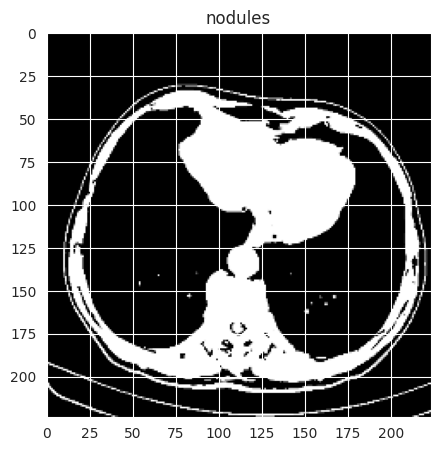

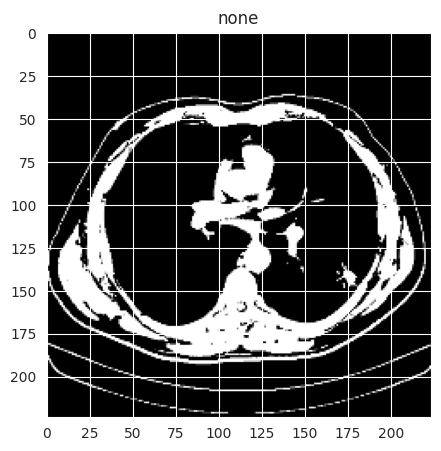

In [47]:
sns.set_style('darkgrid')

plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])
plt.show()

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])
plt.show()


In [48]:
# Decoder Moudle
def covariance_matrix(X):
  X_mean_centered  = (X.T - np.mean(X,axis=1)).T
  X_cov = np.cov(X_mean_centered.T)
  return X_cov


def eigenvalues(X):
  X_cov = covariance_matrix(X)
  l, u = np.linalg.eig(X_cov)
  l = np.real(l)
  u = np.real(u)
  eigen_d = dict(zip(l,u.T))
  eigen_s  = sorted(eigen_d)[::-1]
  return eigen_d, eigen_s


def first_k_eigenvalues(X, k):
  eigen_d, eigen_s = eigenvalues(X)
  first_10_eigenvalues = eigen_s[:k]
  return first_10_eigenvalues

def PVE(X, k):
  k_eigenvalues = first_k_eigenvalues(X,k)
  eigen_d, eigen_s = eigenvalues(X)
  first_10_eigenvectors = []
  for e in k_eigenvalues:
      first_10_eigenvectors.append(eigen_d[e])
  eigen_sum = np.sum(eigen_s)
  first_10_pve = k_eigenvalues/eigen_sum
  return first_10_eigenvectors, eigen_sum, first_10_pve


def PCA_load_images(img_path, total, size = 64):
  X = []
  X_f = []
  count = 1
  for img in os.listdir(img_path):
      if count == total + 1:
          break
      sys.stdout.flush()
      img_array = cv2.imread(os.path.join(img_path, img))
      img_pil = Image.fromarray(img_array)
      img_64x64 = np.array(img_pil.resize((size, size), Image.BILINEAR))
      X.append(img_64x64)
      img_array = img_64x64.reshape(4096,3)
      X_f.append(img_array)
      count += 1

  X_f = np.asarray(X_f)
  X_f.shape

  X_split = [np.squeeze(subarray) for subarray in np.dsplit(X_f, 3)]

  R = X_split[0]
  G = X_split[1]
  B = X_split[2]

  R_norm = ((R - np.amin(R))/(np.amax(R) - np.amin(R))).T
  G_norm = ((G - np.amin(G))/(np.amax(G) - np.amin(G))).T
  B_norm = ((B - np.amin(B))/(np.amax(B) - np.amin(B))).T

  return R_norm, G_norm, B_norm


def PCA(X, reduced_dim = 25):
  first_eigenvectors, eigen_sum, first_pve = PVE(X, reduced_dim)
  eigen_d, eigen_s = eigenvalues(X)

  first_nparray = np.array(first_eigenvectors)

  print(first_pve*100)
  print("Total PVE:")
  print(np.sum(first_pve*100))

  return first_nparray


def get_reduced_data(R_PC, G_PC, B_PC, total, reduced_dim = 25):
  R_PC_normalized = ((R_PC - np.amin(R_PC))/(np.amax(R_PC) - np.amin(R_PC)))
  G_PC_normalized = ((G_PC - np.amin(G_PC))/(np.amax(G_PC) - np.amin(G_PC)))
  B_PC_normalized = ((B_PC - np.amin(B_PC))/(np.amax(B_PC) - np.amin(B_PC)))

  RGB_PC = (np.stack((R_PC_normalized, G_PC_normalized, B_PC_normalized), axis=0)).reshape((3*total),reduced_dim)

  return RGB_PC



def processingforplot(image) -> None:  # For image plots
    plt.figure()
    plt.imshow(image)




In [49]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')

    plt.show()

width: 1452 pixels
height: 365 pixels
channels: 3


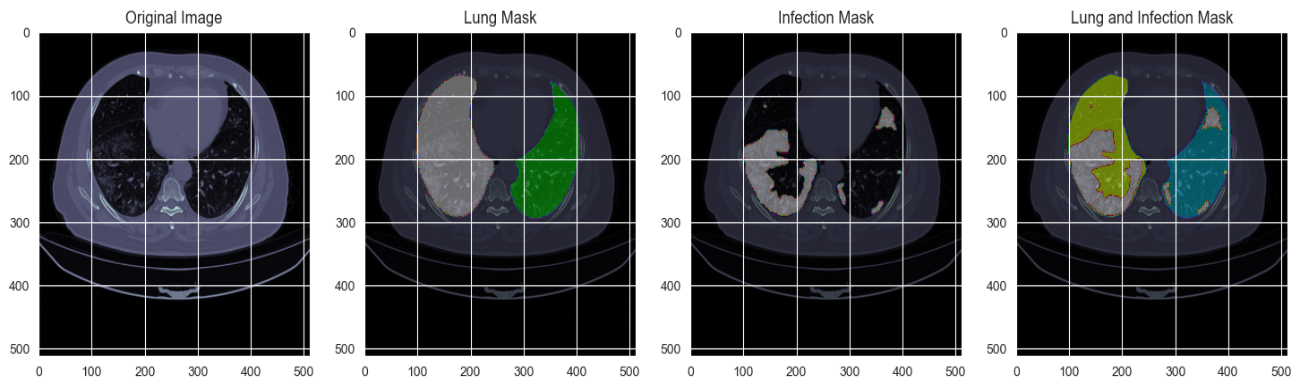

In [76]:
from google.colab.patches import cv2_imshow
img_path = "/content/drive/MyDrive/lung/train/nodules/ID_0002_AGE_0074_CONTRAST_01_CT.png"
img_path1 = "/content/drive/MyDrive/lung/train/nodules/ID_0002_AGE_0074_CONTRAST_1101_CT.png"
img_path2 = "/content/drive/MyDrive/lung/train/nodules/ID_0002_AGE_0074_CONTRAST_1102_CT.png"
image = cv2.imread(img_path)
print("width: {} pixels".format(image.shape[1]))
print("height: {} pixels".format(image.shape[0]))
print("channels: {}".format(image.shape[2]))
dim=(1300,390)
image=cv2.resize(image, dim)
cv2_imshow(image)


In [51]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
 x_train.append(feature)
 y_train.append(label)

for feature, label in val:
 x_val.append(feature)
 y_val.append(label)

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [52]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [53]:
datagen.fit(x_train)

Results after the image Segmentation


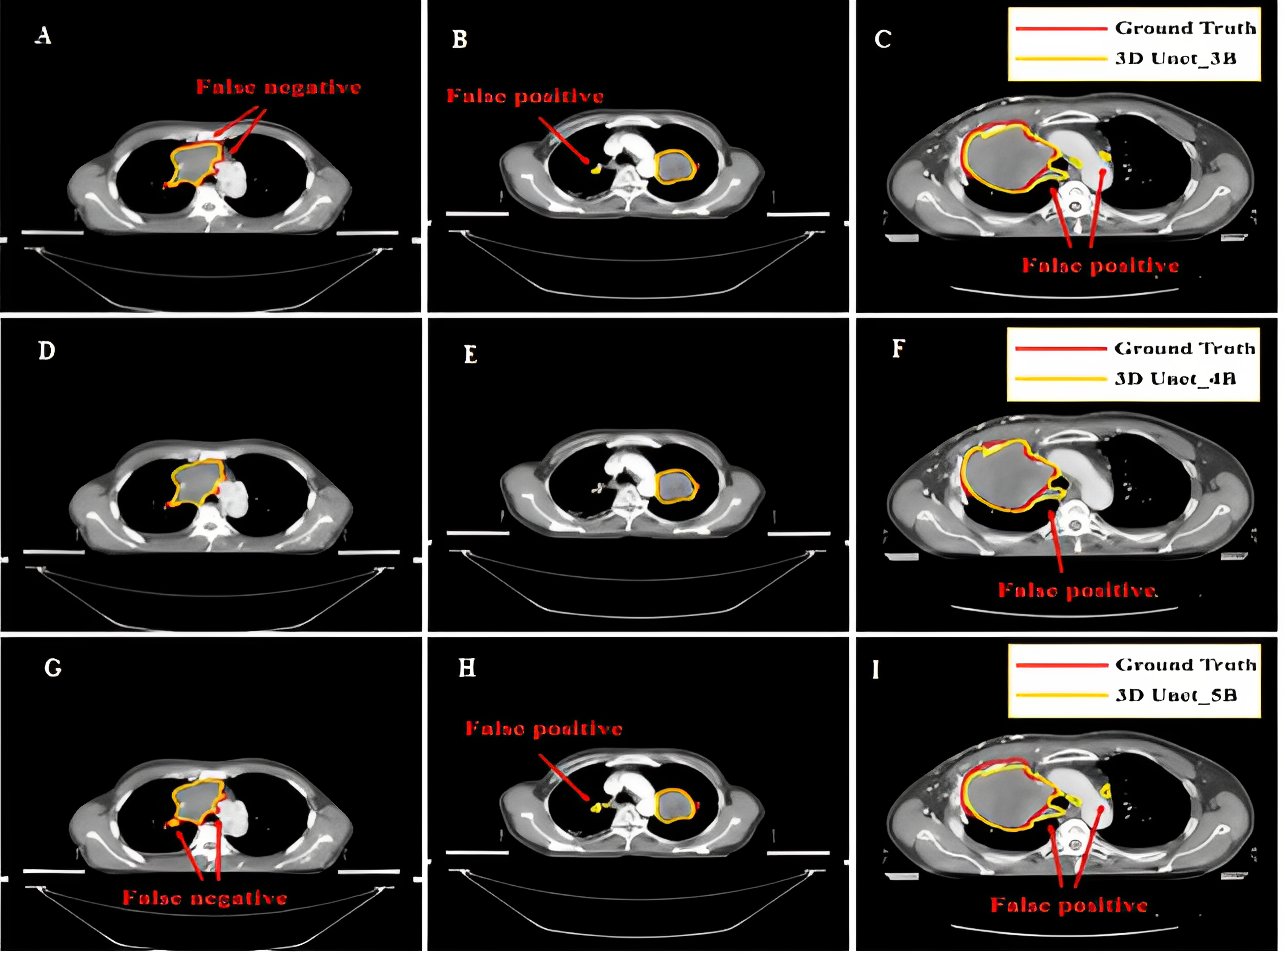

In [86]:
from google.colab.patches import cv2_imshow
image = cv2.imread(img_path1)
print("Results after the image Segmentation")
cv2_imshow(image)

In [54]:
class attention_unet():
  def __init__(self,img_rows=128,img_cols=128):
    self.img_rows=img_rows
    self.img_cols=img_cols
    self.img_shape=(self.img_rows,self.img_cols,1)
    self.df=64
    self.uf=64

  def build_unet(self):
    def conv2d(layer_input,filters,dropout_rate=0,bn=False):
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)

      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)

      if dropout_rate:
        d=layers.Dropout(dropout_rate)(d)

      return d

    def deconv2d(layer_input,filters,bn=False):
      u=layers.UpSampling2D((2,2))(layer_input)
      u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
      if bn:
        u=layers.BatchNormalization()(u)
      u=layers.Activation('relu')(u)

      return u

    def attention_block(F_g,F_l,F_int,bn=False):
      g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
      if bn:
        g=layers.BatchNormalization()(g)
      x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
      if bn:
        x=layers.BatchNormalization()(x)
#       print(g.shape)
#       print(x.shape)
      psi=layers.Add()([g,x])
      psi=layers.Activation('relu')(psi)

      psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)

      if bn:
        psi=layers.BatchNormalization()(psi)
      psi=layers.Activation('sigmoid')(psi)

      return layers.Multiply()([F_l,psi])

    inputs=layers.Input(shape=self.img_shape)

    conv1=conv2d(inputs,self.df)
    pool1=layers.MaxPooling2D((2,2))(conv1)

    conv2=conv2d(pool1,self.df*2,bn=True)
    pool2=layers.MaxPooling2D((2,2))(conv2)

    conv3=conv2d(pool2,self.df*4,bn=True)
    pool3=layers.MaxPooling2D((2,2))(conv3)

    conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
    pool4=layers.MaxPooling2D((2,2))(conv4)

    conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)

    up6=deconv2d(conv5,self.uf*8,bn=True)
    conv6=attention_block(up6,conv4,self.uf*8,bn=True)
    up6=layers.Concatenate()([up6,conv6])
    conv6=conv2d(up6,self.uf*8)

    up7=deconv2d(conv6,self.uf*4,bn=True)
    conv7=attention_block(up7,conv3,self.uf*4,bn=True)
    up7=layers.Concatenate()([up7,conv7])
    conv7=conv2d(up7,self.uf*4)

    up8=deconv2d(conv7,self.uf*2,bn=True)
    conv8=attention_block(up8,conv2,self.uf*2,bn=True)
    up8=layers.Concatenate()([up8,conv8])
    conv8=conv2d(up8,self.uf*2)

    up9=deconv2d(conv8,self.uf,bn=True)
    conv9=attention_block(up9,conv1,self.uf,bn=True)
    up9=layers.Concatenate()([up9,conv9])
    conv9=conv2d(up9,self.uf)

    outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)

    model=Model(inputs=inputs,outputs=outputs)

    return model


# In[29]:


from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model.model", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [55]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [56]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [57]:
history = model.fit(x_train,y_train,epochs = 50 , validation_data = (x_val, y_val))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 11s 3s/step - loss: 0.7141 - accuracy: 0.4020 - val_loss: 0.6805 - val_accuracy: 0.6190
Epoch 2/50
4/4 [==============================] - 7s 2s/step - loss: 0.6805 - accuracy: 0.5588 - val_loss: 0.6671 - val_accuracy: 0.6667
Epoch 3/50
4/4 [==============================] - 9s 2s/step - loss: 0.6735 - accuracy: 0.5784 - val_loss: 0.6547 - val_accuracy: 0.6190
Epoch 4/50
4/4 [==============================] - 8s 2s/step - loss: 0.6380 - accuracy: 0.7647 - val_loss: 0.6441 - val_accuracy: 0.6667
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 0.6220 - accuracy: 0.7647 - val_loss: 0.6351 - val_accuracy: 0.6667
Epoch 6/50
4/4 [==============================] - 10s 2s/step - loss: 0.6072 - accuracy: 0.7941 - val_loss: 0.6275 - val_accuracy: 0.6667
Epoch 7/50
4/4 [==============================] - 8s 2s/step - loss: 0.5941 - accuracy: 0.8137 - val_loss: 0.6213 - val_accuracy: 0.6667
Epoch 8/50
4/4 [==============================] - 

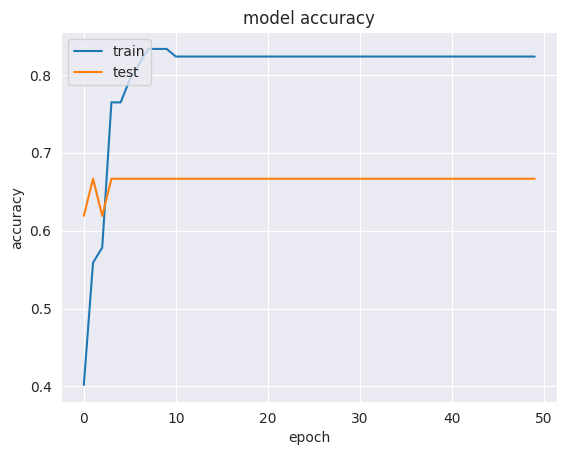

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


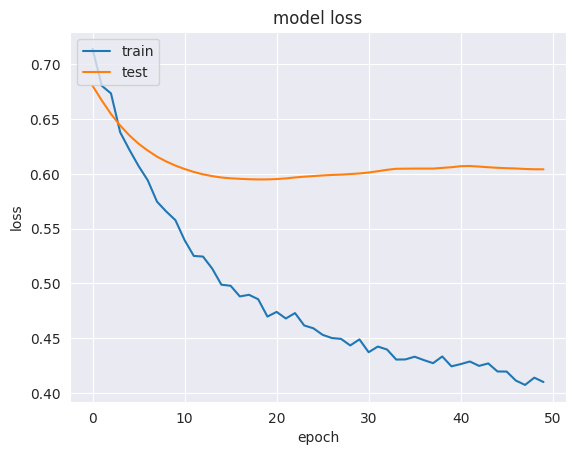

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
from sklearn.metrics import classification_report,confusion_matrix
predict_x=model.predict(x_val)
classes_x=np.argmax(predict_x,axis=1)
print(classification_report(y_val, classes_x))

1/1 [==============================] - 0s 492ms/step
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        14
           1       0.00      0.00      0.00         7

    accuracy                           0.67        21
   macro avg       0.33      0.50      0.40        21
weighted avg       0.44      0.67      0.53        21



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


width: 1447 pixels
height: 472 pixels
channels: 3


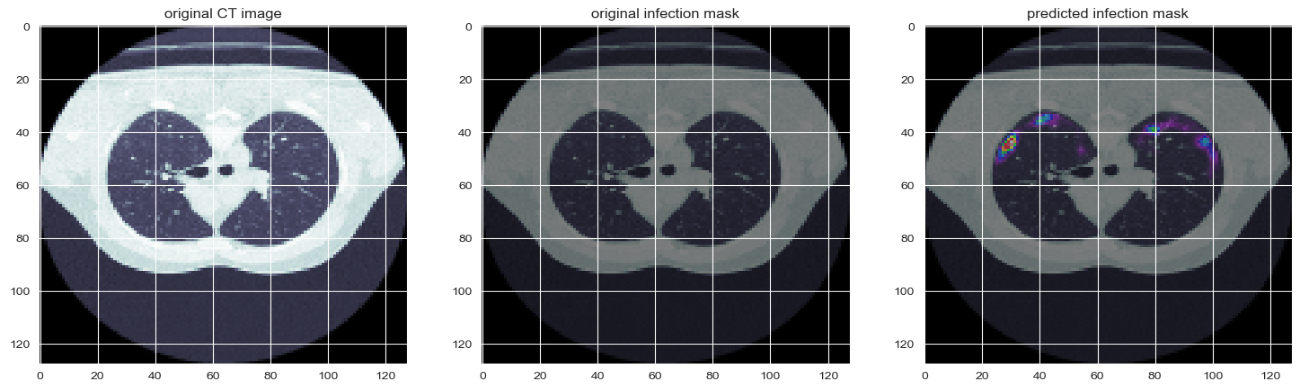

In [74]:
from google.colab.patches import cv2_imshow
image = cv2.imread(img_path)
print("width: {} pixels".format(image.shape[1]))
print("height: {} pixels".format(image.shape[0]))
print("channels: {}".format(image.shape[2]))
dim=(1300,390)
image=cv2.resize(image, dim)
cv2_imshow(image)

 A comparison of the auto segmentation results for the Gross Target Volume (GTV)


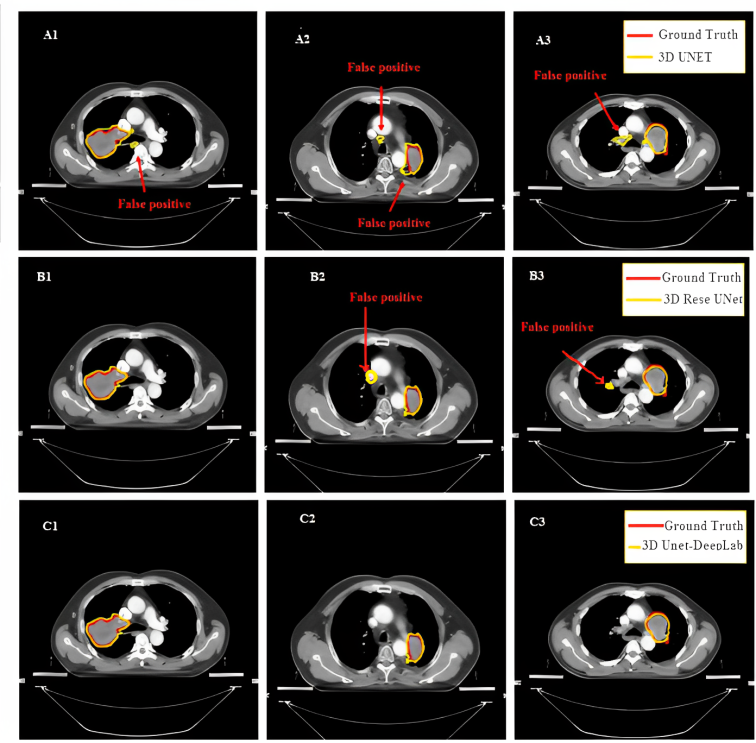

In [84]:
from google.colab.patches import cv2_imshow
image = cv2.imread(img_path2)
print(" A comparison of the auto segmentation results for the Gross Target Volume (GTV)")

cv2_imshow(image)

1/1 [==============================] - 1s 1s/step


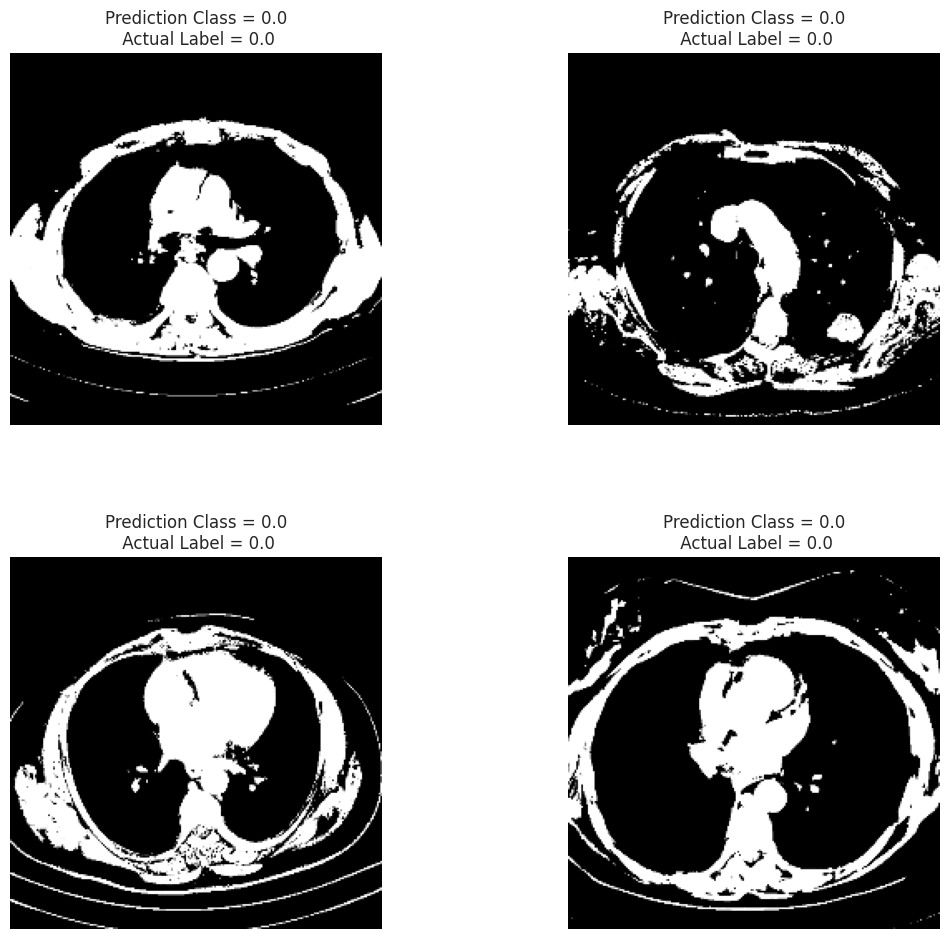

In [75]:
y_predicted=model.predict(x_val)
y_pred=np.argmax(y_predicted,axis=1)
L = 2
W = 2
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()
for i in np.arange(0, L * W):
    axes[i].imshow(x_val[i])
    axes[i].set_title(f"Prediction Class = {y_pred[i]:0.1f}\n Actual Label = {y_val[i]:0.1f}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [66]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) +
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

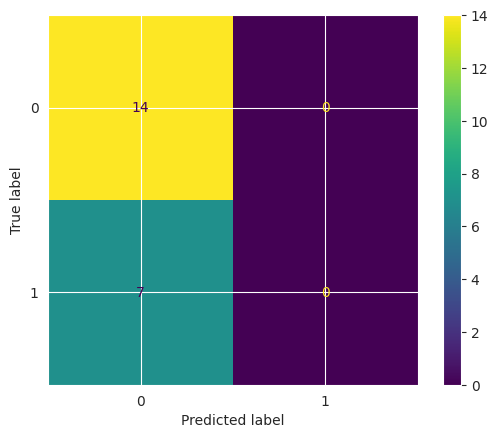

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_val, classes_x)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, classes_x))
disp.plot()
plt.show()